# Multiple Linear Regression of Cryptocurrency

The following model I have developed to demonstrate how to extract, transform and load data and build a pipeline based on a Multiple Regression problem. I aim to forecast Bitcoin (C$) prices by extrapolating historical data, training, validating and testing the model before evaluating its accuracy using a benchmark score.

I am looking to predict the closing price (dependent variable) based on its relationship with other intraday price and volume information (independent variables).

## Performance Measure Selection
For the purpose of a multiple regression I am selecting the Root Mean Square Error (RMSE) to measure the overall degree of error when making model my predictions. 

$$ RMSE(X,h) = \sqrt {\frac{1}{m} \sum_{i=1}^{m}(h(x^ {i})-y^ {i})^2} $$

In [1]:
import pandas as pd
import os
import tarfile
import urllib

DOWNLOAD_URL = "https://ca.finance.yahoo.com/quote/BTC-CAD/history?p=BTC-CAD"
BITCOIN_PATH = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")
BITCOIN_URL = DOWNLOAD_URL + "C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv"

def fetch_bitcoin_data(bitcoin_url=BITCOIN_URL, bitcoin_path=BITCOIN_PATH):
    os.makedirs(bitcoin_path, exist_ok=True)
    tgz_path = os.path.join(bitcoin_path)
    urllib.request.urlretrieve(bitcoin_url, tgz_path)
    bitcoin_tgz = tarfile.open(tgz_path)
    bitcoin_tgz.extract_all(path=bitcoin_path)
    bitcoin_tgz.close()
    
def load_bitcoin_data(bitcoin_path=BITCOIN_PATH):
    csv_path = os.path.join(bitcoin_path)
    return pd.read_csv(csv_path)

Start by loading the Canadian denominated Bitcoin data below.

In [2]:
btc_cad = load_bitcoin_data()

Each column represents a different feature, for example 'High', 'Low' and 'Close' prices are all features. These features are also known as attributes, input, or predictor variables which can be used to ascertain a stock price prediction (called labels, output, or target variables).

In [3]:
# get stock info
print(btc_cad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       366 non-null    object 
 1   Open       362 non-null    float64
 2   High       362 non-null    float64
 3   Low        362 non-null    float64
 4   Close      362 non-null    float64
 5   Adj Close  362 non-null    float64
 6   Volume     362 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.1+ KB
None


The following method gives a breakdown of the first and last entries in the dataset.

In [4]:
btc_cad.info

<bound method DataFrame.info of            Date          Open          High           Low         Close  \
0    2020-04-21   9718.074219   9838.333008   9728.248047   9763.935547   
1    2020-04-22   9762.682617  10125.870120   9747.394531  10096.278320   
2    2020-04-23  10102.092770  10533.734380  10009.763670  10451.163090   
3    2020-04-24  10457.432620  10678.707030  10457.432620  10642.806640   
4    2020-04-25  10642.216800  10773.176760  10601.609380  10669.635740   
..          ...           ...           ...           ...           ...   
361  2021-04-17  76964.703130  78268.406250  75503.000000  75906.359380   
362  2021-04-18  75928.953130  76373.718750  66081.828130  70374.906250   
363  2021-04-19  70344.109380  71803.609380  68107.265630  69788.234380   
364  2021-04-20           NaN           NaN           NaN           NaN   
365  2021-04-21  71509.304690  71556.757810  71132.078130  71477.757810   

        Adj Close        Volume  
0     9763.935547  4.624843e+10  

Using the describe() method to view summary statistics helps define the average values or range of data involved in this dataset, as well as a measure of dispersion about its mean.

In [5]:
btc_cad.describe()

,Open,High,Low,Close,Adj Close,Volume
count,362.000000,362.000000,362.000000,362.000000,362.000000,3.620000e+02
mean,29707.219509,30555.675634,28874.214073,29864.750594,29864.750594,5.364938e+10
std,21773.554061,22482.286397,20992.767955,21845.825379,21845.825379,3.297456e+10
min,9718.074219,9838.333008,9728.248047,9763.935547,9763.935547,1.663903e+10
25%,13373.918455,13684.485110,13056.077148,13421.041262,13421.041262,3.142625e+10
50%,16520.156250,17169.826175,16253.259275,16921.556640,16921.556640,4.716901e+10
75%,44679.113283,46686.911130,41998.325195,45279.527345,45279.527345,6.929678e+10
max,79623.851560,81445.671880,77726.054690,79598.406250,79598.406250,4.470000e+11


So I can tell the average closing price is C$29,865 to the nearest integer. 

There isn't much data to work from (one years worth exactly), but I would like to create a dataframe object from the price data and try and use it to forecast future price information.

## Import Libraries
The bulk of the libraries I will use are as follows. This may change as I progress.

In [6]:
import numpy as np
from sklearn import linear_model
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

Taking a look at which columns are present in the dataset gives me:

In [7]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

And now lets see the first and last 5 entries in the table:

In [8]:
btc_cad.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-21,9718.074219,9838.333008,9728.248047,9763.935547,9763.935547,4.624843e+10
1,2020-04-22,9762.682617,10125.870120,9747.394531,10096.278320,10096.278320,4.716635e+10
2,2020-04-23,10102.092770,10533.734380,10009.763670,10451.163090,10451.163090,6.119120e+10
3,2020-04-24,10457.432620,10678.707030,10457.432620,10642.806640,10642.806640,4.881932e+10
4,2020-04-25,10642.216800,10773.176760,10601.609380,10669.635740,10669.635740,4.643028e+10


And now the tail of the dataframe.

In [9]:
btc_cad.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2021-04-17,76964.70313,78268.40625,75503.00000,75906.35938,75906.35938,8.272967e+10
362,2021-04-18,75928.95313,76373.71875,66081.82813,70374.90625,70374.90625,1.220000e+11
363,2021-04-19,70344.10938,71803.60938,68107.26563,69788.23438,69788.23438,8.183693e+10
364,2021-04-20,NaN,NaN,NaN,NaN,NaN,NaN
365,2021-04-21,71509.30469,71556.75781,71132.07813,71477.75781,71477.75781,8.495634e+10


# Cleaning the Data
A brief look at the summary info for the dataset tells me there are a different number of date values compared to the rest of the column entries. This will need to be addressed, followed by any missing values, NaN, 'isnull' or entries with 'zero'. I can also see the different number 'count' for entries using the count() method:

In [10]:
btc_cad.count()

Date         366
Open         362
High         362
Low          362
Close        362
Adj Close    362
Volume       362
dtype: int64

First I just want to see what shape the dataframe is.

In [11]:
btc_cad.shape

(366, 7)

So it's 366 rows by 7 columns or a (366x7) matrix.

Next, to find the total number of missing entries.

In [12]:
bitcoin_missing_values_count = btc_cad.isnull().sum()
bitcoin_missing_values_count[0:7]

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

Further examination allows me to calculate the total number of rows containing missing data points as a percentage of the total number of rows in the dataframe.

In [13]:
total_bitcoin = np.product(btc_cad.shape)
total_missing_bitcoin = bitcoin_missing_values_count.sum()

percent_missing_values = (total_missing_bitcoin/total_bitcoin) * 100
print(percent_missing_values)

0.936768149882904


From this I can see that just under 1% of the total values are missing. I can either choose to leave them out completely (as they may not really affect my model for the purpose of this exercise) or use imputed values such as the mean or median.

## Removing Rows
Having checked the csv file I can determine that there is no real reason for the missing values (null entries) for these dates. At first I thought these missing values might be due to public holidays but because Bitcoin is a currency, it appears to be traded OTC (Over The Counter) beyong normal trading hours throughout the day, seven days a week. As a result I have chosen to leave these missing values out using the dropna() method to eliminate them.

In [14]:
btc_cad = btc_cad.dropna(axis=0)

In [15]:
btc_cad.count()

Date         362
Open         362
High         362
Low          362
Close        362
Adj Close    362
Volume       362
dtype: int64

This time there are exactly 362 rows for each column. It's important to set the argument (axis=0) otherwise dropping the values doesn't work. 

## Removing Columns (Feature Selection)

The values in the 'Adj Close' column are exactly the same as in the 'Close' column so I will remove 'Adj Close' completely from the dataset in an attempt to regularize the model. This is unecessary data which can be removed as it could contribute to bias and bleed into the test data. It's better to reduce the overall number of variables particularly removing those which are not relevant.

In [16]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [17]:
del btc_cad['Adj Close']

In [18]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Next, I will store the independent variables (features) in a dataframe called bitcoin which can be used for further analysis.

In [19]:
bitcoin = btc_cad

# Exploratory Data Analysis

The mean value for the Bitcoin (CAD) close price is C$ 29,864.75 and from the summary statistics using 'describe()' I can also see the maximum values in the upper-quartile range have been tested regularly.

As there are no dividends or stock splits because Bitcoin is a currency (medium of exchange / store of value), only 6 columns are of any use to me in this particular dataset: Date, Open, High, Low, Close and Volume. Printing the first 5 lines of the dataframe gives:

In [20]:
print(bitcoin[:5])

         Date          Open          High           Low         Close  \
0  2020-04-21   9718.074219   9838.333008   9728.248047   9763.935547   
1  2020-04-22   9762.682617  10125.870120   9747.394531  10096.278320   
2  2020-04-23  10102.092770  10533.734380  10009.763670  10451.163090   
3  2020-04-24  10457.432620  10678.707030  10457.432620  10642.806640   
4  2020-04-25  10642.216800  10773.176760  10601.609380  10669.635740   

         Volume  
0  4.624843e+10  
1  4.716635e+10  
2  6.119120e+10  
3  4.881932e+10  
4  4.643028e+10  


## Visualizing the Data
Let's take a look at plotting the different price data over time. This first plot will have the different OHLC prices for the last year.

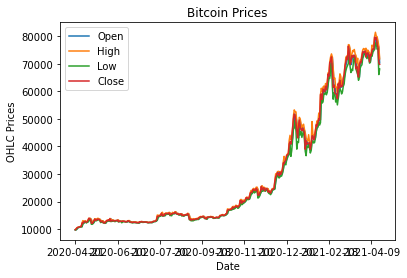

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

data = {'Date': bitcoin.Date[0:-1], 'Open': bitcoin.Open[0:-1], 'High': bitcoin.High[0:-1], 'Low': bitcoin.Low[0:-1], 
        'Close': bitcoin.Close[0:-1]}

df = pd.DataFrame(data,columns=['Date','Open','High','Low','Close'])
df.plot(x ='Date', y=['Open','High','Low','Close'], kind = 'line')
plt.title('Bitcoin Prices')          # the chart title
plt.xlabel('Date')                   # the x-axis label (time series)
plt.ylabel('OHLC Prices')            # the y-axis label (OHLC prices over time)
plt.legend()
plt.show()


### Correlation
The first stage of any feature selection process for a linear regression model should involve checking the degree of correlation between the features and the target variable. (Be careful and perform the correlation function on 'bitcoin' dataframe, not the 'data' dictionary.

In [22]:
correlation = bitcoin.corr()
print(correlation)

            Open      High       Low     Close    Volume
Open    1.000000  0.999003  0.998283  0.997880  0.584975
High    0.999003  1.000000  0.998194  0.999188  0.592747
Low     0.998283  0.998194  1.000000  0.998735  0.569046
Close   0.997880  0.999188  0.998735  1.000000  0.582709
Volume  0.584975  0.592747  0.569046  0.582709  1.000000


I would expect the opening and closing prices to be defined by the range of the high and low daily prices so all of these values tend to move within a fairly narrow band. There is a strong degree of positive correlation between these time-series values. I can also determine there is a less powerful degree of association between the volume of currency traded and its closing price (0.582709), but a positive relationship nonetheless. 

 Assuming I wanted to find the top three highest correlated features I could use the .abs() and .nlargest() methods:

In [23]:
print(bitcoin.corr().abs().nlargest(3, 'Close').index)          # to find the top 3 features with highest correlation values

Index(['Close', 'High', 'Low'], dtype='object')


In [24]:
print(bitcoin.corr().abs().nlargest(3, 'Close').values[:,3])         # top 3 correlation values

[1.         0.99918803 0.99873489]


Firstly, the perfectly correclated value of 1.0 represents the 'Close' price correlation with itself, but the nest two correlation values of 0.99918803 and 0.99873489 represent those of the daily 'High' and 'Low' resepectively.

Remember, this would only be necessary if I wanted to include only those features with the top 3 correlation scores. For the purpose of this model that would be the open, high and low prices but I want to include the volume also and have decided to keep all 4 features. Next I intend to look at a scatter plot to show the relationship between some of these variables starting with the daily high and close prices.

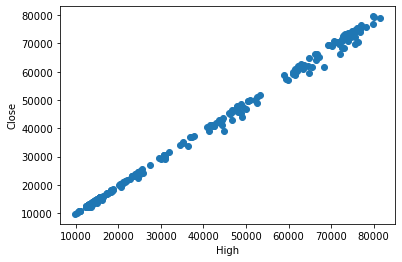

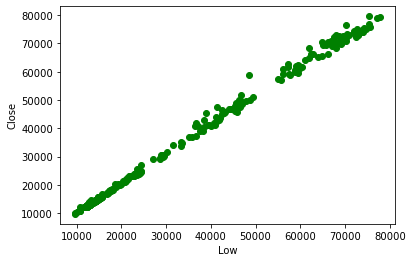

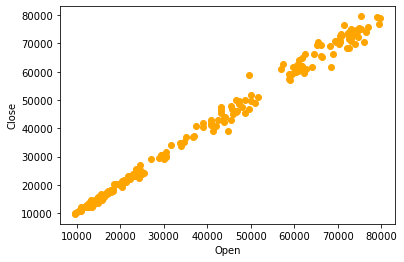

In [51]:
plt.scatter(data['High'], data['Close'], marker='o')
plt.xlabel('High')
plt.ylabel('Close')
plt.show()

plt.scatter(data['Low'], data['Close'], marker='o', color='green')
plt.xlabel('Low')
plt.ylabel('Close')
plt.show()

plt.scatter(data['Open'], data['Close'], marker='o', color='orange')
plt.xlabel('Open')
plt.ylabel('Close')
plt.show()

A strong positive linear relationship exists between the High, Low and Open prices with the Close but the degree of correlation decreases with High, Low and Open prices respectively. Also this can be checked against the 4th row of the correlation matrix under the row with 'Close' in the entry.

And finally the relationship plot of daily volume against the closing prices. I can see there is one outlier on the right hand side.

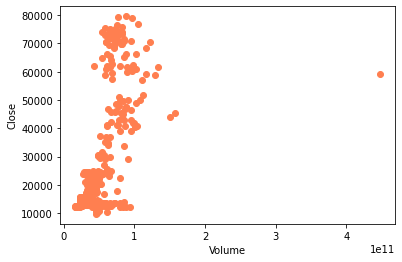

In [61]:
plt.scatter(bitcoin['Volume'], bitcoin['Close'], marker='o', color='coral')
plt.xlabel('Volume')
plt.ylabel('Close')
plt.show()

I decided to look at the closing prices in a histogram explained by the frequency of values against price. I know that earlier in the year there were a large number of cumulative values within the ten to twenty thousand dollar range. The extra weighting given to these observations have obviously caused a fairly low mean value of approximately thirty thousand dollars, but the cryptocurrency finished up at 71.5 thousand dollars by April 2021. The overall range of price values has been divided into 20 separate bins for some clarity.

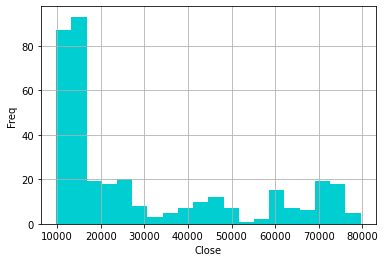

In [47]:
mean_close_price = bitcoin['Close'].hist(bins=20, color='darkturquoise')
plt.xlabel('Close')
plt.ylabel('Freq')
plt.show()

The Volume variable will need re-scaling in order for me to amend the range of the data because for some reason the x-axis is using strange markers. There is a positive relationship between the them but currency volume seems to trade within a fairly distinct range.

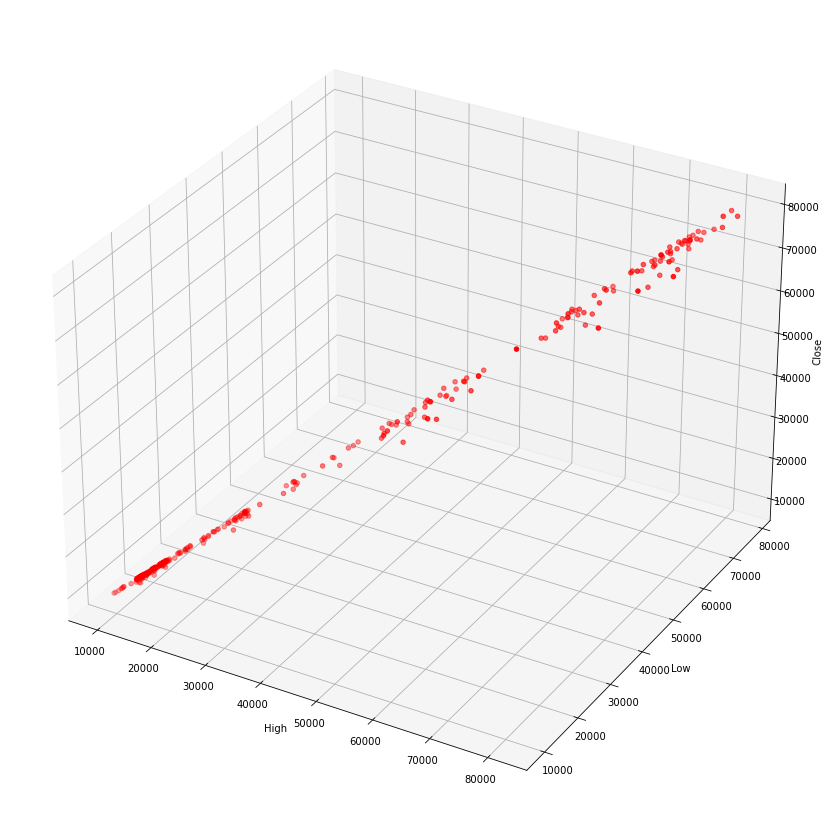

In [57]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['High'],
    df['Low'],
    df['Close'],
    c='r')

ax.set_xlabel("High")
ax.set_ylabel("Low")
ax.set_zlabel("Close")
plt.show()

### Mean Prices
Taking a look at some other characteristics of the data, starting with frequency distributions of the mean close price.

### Creating Buckets
Dividing the values for each type of price into different interval ranges for every C$10,000 mark will help when creating histograms and frequency distributions.

In [ ]:
open_bkt_1 = bitcoin['Open'] > 0 & bitcoin['Open'] <= 10000
open_bkt_2 = bitcoin['Open'] > 10000 & bitcoin['Open'] <= 20000
open_bkt_3 = bitcoin['Open'] > 20000 & bitcoin['Open'] <= 30000
open_bkt_4 = bitcoin['Open'] > 30000 & bitcoin['Open'] <= 40000
open_bkt_5 = bitcoin['Open'] > 40000 & bitcoin['Open'] <= 50000
open_bkt_6 = bitcoin['Open'] > 50000 & bitcoin['Open'] <= 60000
open_bkt_7 = bitcoin['Open'] > 60000 & bitcoin['Open'] <= 70000
open_bkt_8 = bitcoin['Open'] > 70000 & bitcoin['Open'] <= 80000

print(open_bkt_1)
print(open_bkt_2)
print(open_bkt_3)
print(open_bkt_4)
print(open_bkt_5)
print(open_bkt_6)
print(open_bkt_7)
print(open_bkt_8)

If the mean of the daily 'Open' price = C$29,707.22, then I can find out how many values are above or below the average.

In [ ]:
bitcoin['Open'].loc[bitcoin['Open'] > 29707.22]

So there are 121 values greater than the mean daily opening price. Calculating this as a percentage of the total number of observations gives:

In [ ]:
(121 / 162) * 100

The mean of the daily 'High' price is C$30,555.68.

In [ ]:
bitcoin['High'].loc[bitcoin['High'] > 30555.68]

Or, in percentage terms gives 76%

In [ ]:
(123 / 162) * 100

Now for the mean of the daily 'Low' price which is C$28,874.21.

In [ ]:
bitcoin['Low'].loc[bitcoin['Low'] > 28874.21]

In [ ]:
(122 / 162) * 100

And finally the mean for the daily 'Close' price is C$29,864.75.

In [ ]:
bitcoin['Close'].loc[bitcoin['Close'] > 29864.75]

In [ ]:
(121 / 162) * 100

I can tell for all of these price categories that roughly 75% of the values lie above the mean which should indicate their frequency distributions are positively skewed.

In [ ]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    

    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [ ]:
bins = create_bins(lower_bound=0,
                   width=10000,
                   quantity=7)

bins

In [ ]:
def find_bin(value, bins):
    """ bins is a list of tuples, like [(0,10000), (10000, 20000), (20000, 30000)],
        binning returns the smallest index i of bins so that
        bin[i][0] <= value < bin[i][1]
    """
    
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    return -1

In [ ]:
from collections import Counter

bins = create_bins(lower_bound=0,
                   width=10000,
                   quantity=7)

print(bins)

open_price = bitcoin['Open']

binned_open_price = []

for value in open_price:
    bin_index = find_bin(value, bins)
    print(value, bin_index, bins[bin_index])
    binned_open_price.append(bin_index)
    
frequencies = Counter(binned_open_price)
print(frequencies)

In [ ]:
open_price = bitcoin['Open']
bins2 = pd.IntervalIndex.from_tuples(bins)
categorical_object = pd.cut(open_price, bins2)
print(categorical_object)

In [ ]:
bins2 = pd.IntervalIndex.from_tuples(bins, closed="left")
categorical_object = pd.cut(open_price, bins2)
print(categorical_object)

Next I want to split the data into predictors and a target variable, containing all my feature columns in one table variable and the target variable in a column vector. The prediction target can be assigned as follows:

In [ ]:
y = bitcoin.Close

The features are a selection of columns used to predict 'y', including

In [ ]:
bitcoin_features = ['Date','Open','High','Low','Volume']

In [ ]:
X = bitcoin[bitcoin_features]

So currently I can determine that Bitcoin was trading well below the mean (12 months ago) and more recently it's trading at roughly 130% above the mean for the last 12 month period. 

Time for some interval analysis where I will attempt to place OHLC values in different interval buckets based on the number of counts, but first I need to create a plot.

In [ ]:
y.describe()

In [ ]:
y.mean()

In [ ]:
y.std()

In [ ]:
X.describe()

In [ ]:
X.mean()

In [ ]:
X.std()